This NB explores burn vs. shortfall for a given shortfall_fraction, the various miner metrics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
# from shortfall.network import *
from shortfall.network import REWARD_DECAY, BASELINE_GROWTH
from shortfall.network_mechafil import DEFAULT_NETWORK_CONFIG
from shortfall.network_mechafil import NetworkConfig as MechafilNetworkConfig
from shortfall.network_mechafil import NetworkState as MechafilNetworkState
from shortfall.network_mechafil import compute_mechafil_trajectories
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.wrappers as wrappers

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from datetime import date, timedelta

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 5 * YEAR + 1
stats_interval = DAY

In [4]:
today_minus_two_days = date.today() - timedelta(days=2)
low_rbp = 3
ob_low_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=low_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=days
)

med_rbp = 6
ob_med_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=med_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=days
)

hi_rbp = 15
ob_hi_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=hi_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=days
)

Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories


In [ ]:
# def get_burn_stats(network_config, max_shortfall_possible, power, shortfall_pct_pow, 
#                    shortfall_frac=0.0, miner_balance=0):
#     """
#     max_shortfall_possible - the maximum amount of shortfall that is possible at the protocol level
#     shortfall_frac - a value between [0,max_shortfall_possible] that is the shortfall to take
#     token_lease_fee - the borrowing rate for the tokens that are not acquired through shortfall
#     """
#     burn_miner_factory = BurnShortfallMinerState.factory(balance=miner_balance, 
#                                                          max_shortfall_fraction=max_shortfall_possible,
#                                                          shortfall_take_rate_exponent=shortfall_pct_pow)

#     burn_pl_cfg = SimConfig(
#         network=network_config,
#         strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, shortfall_frac),
#         miner_factory=burn_miner_factory,
#     )
#     stats_burn = Simulator(burn_pl_cfg).run_all(days, stats_interval)
#     return pd.DataFrame(data=stats_burn)

# def get_repay_stats(network_config, miner_balance, power, max_fee_reward_fraction, shortfall_take_amount, 
#                     token_lease_fee=0.2):
#     max_repayment_term = 3. * 365 * DAY
#     repay_miner_factory = RepayRatchetShortfallMinerState.factory(
#         balance=miner_balance,
#         max_repayment_term=max_repayment_term,
#         max_fee_reward_fraction=max_fee_reward_fraction,
#         reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
#     )

#     repay_cfg = SimConfig(
#         network=network_config,
#         strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, shortfall_take_amount),
#         miner_factory=repay_miner_factory,
#     )
#     stats_repay = Simulator(repay_cfg).run_all(days, stats_interval)
#     return pd.DataFrame(data=stats_repay)

In [5]:
# global config
delta=0.1
shortfall_frac_vec = np.arange(0.0,0.4+delta,delta)

miner_balance=0
token_lease_fee=0.0
power = 50  # noop

# burn config
max_shortfall_possible = 0.5  # noop
shortfall_pct_pow_vec = np.linspace(0,1,5)

# repay config
max_fee_reward_fraction_vec = np.arange(0.1,0.2+.02,.02)

# setup network configs
low_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_low_sa_low,
                        token_lease_fee=0.0)

medium_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_med_sa_low,
                        token_lease_fee=0.0)

high_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_hi_sa_low,
                        token_lease_fee=0.0)

In [6]:
burn_with_shortfall_results = {}
repay_with_shortfall_results = {}

rbp_onboard_vec = [3,6,15]
networking_config_vec = [low_onboarding_network_config, medium_onboarding_network_config, high_onboarding_network_config]

pbar = tqdm(total=len(shortfall_frac_vec)*len(networking_config_vec))
for rbp_onboard, network_config in zip(rbp_onboard_vec, networking_config_vec):
    for shortfall_frac in shortfall_frac_vec:
        for shortfall_pct_pow in shortfall_pct_pow_vec:
            # set token lease fee to 0, this simulates the scenario where the remainder of the tokens
            # needed for pledge come from the miner's wallet
            key = '%0.02f,%0.02f,%0.02f' % (rbp_onboard,shortfall_pct_pow, shortfall_frac)
            burn_with_shortfall_df = wrappers.get_burn_stats(
                network_config, 
                power=power, 
                max_shortfall_possible=max_shortfall_possible, 
                shortfall_pct_pow=shortfall_pct_pow,
                sector_duration=days,
                shortfall_frac=shortfall_frac,
                miner_balance=0,
                network_uptake=0,
                fee_structure='linear',
                max_fee_frac=0 # a noop
            )
            burn_with_shortfall_results[key] = burn_with_shortfall_df

        for max_fee_reward_fraction in max_fee_reward_fraction_vec:
            key = '%0.02f,%0.02f,%0.02f' % (rbp_onboard,max_fee_reward_fraction, shortfall_frac)
            try:
                repay_df = wrappers.get_repay_stats(
                    network_config, 
                    power=power,
                    max_fee_reward_fraction=max_fee_reward_fraction,
                    sector_duration=days,
                    shortfall_frac=shortfall_frac,
                    miner_balance=0
                )
                repay_with_shortfall_results[key] = repay_df
            except RuntimeError as e:
                # this is an illegal combination of parameters
                print('Skipping due to incorrect parametrization: shortfall=%0.02f max_fee_reward_frac=%0.02f' % (shortfall_frac, max_fee_reward_fraction))
                repay_with_shortfall_results[key] = None
        pbar.update(1)

  0%|          | 0/15 [00:00<?, ?it/s]

Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.10
Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.12
Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.14
Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.16
Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.18
Skipping due to incorrect parametrization: shortfall=0.40 max_fee_reward_frac=0.20


<IPython.core.display.Javascript object>


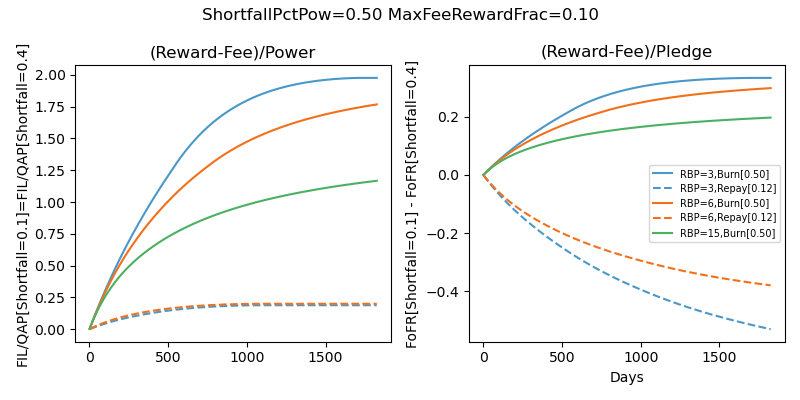

interactive(children=(FloatSlider(value=0.5, description='shortfall_pct_pow', max=1.0, step=0.25), FloatSlider…

<function __main__.update(shortfall_pct_pow=0.5, max_fee_reward_fraction=0.1)>

In [10]:
savedir='/Users/kiran/Documents/hackmd/shortfall'
os.makedirs(savedir, exist_ok=True)
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# def get_income(df):
#     return df.iloc[1:]['reward_earned'] - df.iloc[1:]['fee_burned'] - df.iloc[1:]['lease_fee_accrued'] 

power = 50
def update(shortfall_pct_pow=0.5, max_fee_reward_fraction=0.1):
    ax[0].cla()
    ax[1].cla()
    
#     for ii, shortfall_take_frac in enumerate([0.1, 0.4]):
#         burn_with_shortfall_key = '%0.02f,%0.02f,%0.02f' % (rbp,shortfall_pct_pow, shortfall_take_frac)
#         burn_with_shortfall_df = burn_with_shortfall_results[burn_with_shortfall_key]
#         burn_with_shortfall_income = get_income(burn_with_shortfall_df) if burn_with_shortfall_df is not None else None

#         repay_with_shortfall_key = '%0.02f,%0.02f,%0.02f' % (rbp,max_fee_reward_fraction, shortfall_take_frac)
#         repay_with_shortfall_df = repay_with_shortfall_results[repay_with_shortfall_key]
#         repay_with_shortfall_income = get_income(repay_with_shortfall_df) if repay_with_shortfall_df is not None else None

#         norm_factor = power
#         if burn_with_shortfall_income is not None:
#             ax[0].plot(burn_with_shortfall_income/norm_factor, color=colors[ii](0.6), label='Burn[%0.02f]-Shortfall=%0.02f' % (shortfall_pct_pow,shortfall_take_frac,))
#         if repay_with_shortfall_income is not None:
#             ax[0].plot(repay_with_shortfall_income/norm_factor, color=colors[ii](0.6), linestyle='--', label='Repay[%0.02f]-Shortfall=%0.02f' % (max_fee_reward_fraction, shortfall_take_frac,))

#         if burn_with_shortfall_income is not None:
#             norm_factor = float(burn_with_shortfall_df.iloc[0]['pledge_locked'])
#             ax[1].plot(burn_with_shortfall_income/norm_factor, color=colors[ii](0.6), label='Burn[%0.02f]-Shortfall=%0.02f' % (shortfall_pct_pow,shortfall_take_frac,))
#         if repay_with_shortfall_income is not None:
#             norm_factor = float(repay_with_shortfall_df.iloc[0]['pledge_locked'])
#             ax[1].plot(repay_with_shortfall_income/norm_factor, color=colors[ii](0.6), linestyle='--', label='Repay[%0.02f]-Shortfall=%0.02f' % (max_fee_reward_fraction,shortfall_take_frac,))

    # plot the delta
    for ii, rbp in enumerate(rbp_onboard_vec):
        burn_with_shortfall_key = '%0.02f,%0.02f,0.10' % (rbp, shortfall_pct_pow)
        burn_with_shortfall_df1 = pd.DataFrame(data=burn_with_shortfall_results[burn_with_shortfall_key])
        burn_with_shortfall_income1 = wrappers.get_income(burn_with_shortfall_df1) if len(burn_with_shortfall_df1) > 0 else None
        burn_with_shortfall_key = '%0.02f,%0.02f,0.40' % (rbp, shortfall_pct_pow)
        burn_with_shortfall_df4 = pd.DataFrame(data=burn_with_shortfall_results[burn_with_shortfall_key])
        burn_with_shortfall_income4 = wrappers.get_income(burn_with_shortfall_df4) if len(burn_with_shortfall_df4) > 0 else None

        repay_with_shortfall_key = '%0.02f,%0.02f,0.10' % (rbp,max_fee_reward_fraction)
        repay_with_shortfall_df1 = pd.DataFrame(data=repay_with_shortfall_results[repay_with_shortfall_key])
        repay_with_shortfall_income1 = wrappers.get_income(repay_with_shortfall_df1) if len(repay_with_shortfall_df1) > 0 else None
        repay_with_shortfall_key = '%0.02f,%0.02f,0.40' % (rbp,max_fee_reward_fraction)
        repay_with_shortfall_df4 = pd.DataFrame(data=repay_with_shortfall_results[repay_with_shortfall_key])
        repay_with_shortfall_income4 = wrappers.get_income(repay_with_shortfall_df4) if len(repay_with_shortfall_df4) > 0 else None

        norm_factor = power
        if burn_with_shortfall_income1 is not None and burn_with_shortfall_income4 is not None:
            ax[0].plot((burn_with_shortfall_income1-burn_with_shortfall_income4)/norm_factor, color=colors[ii](0.6), label='RBP=%d,Burn[%0.02f]' % (rbp,shortfall_pct_pow,))
        if repay_with_shortfall_income1 is not None and repay_with_shortfall_income4 is not None:
            ax[0].plot((repay_with_shortfall_income1-repay_with_shortfall_income4)/norm_factor, linestyle='--', color=colors[ii](0.6), label='RBP=%d,Repay[%0.02f]' % (rbp,max_fee_reward_fraction,))

        if burn_with_shortfall_income1 is not None and burn_with_shortfall_income4 is not None:
            norm_factor1 = float(burn_with_shortfall_df1.iloc[0]['pledge_locked'])
            norm_factor4 = float(burn_with_shortfall_df1.iloc[0]['pledge_locked'])
            ax[1].plot(burn_with_shortfall_income1/norm_factor1-burn_with_shortfall_income4/norm_factor4, color=colors[ii](0.6), label='RBP=%d,Burn[%0.02f]' % (rbp,shortfall_pct_pow,))
        if repay_with_shortfall_income1 is not None and repay_with_shortfall_income4 is not None:
            norm_factor1 = float(repay_with_shortfall_df1.iloc[0]['pledge_locked'])
            norm_factor4 = float(repay_with_shortfall_df4.iloc[0]['pledge_locked'])
            ax[1].plot(repay_with_shortfall_income1/norm_factor1-repay_with_shortfall_income4/norm_factor4, linestyle='--', color=colors[ii](0.6), label='RBP=%d,Repay[%0.02f]' % (rbp,max_fee_reward_fraction,))
        
#     ax[0].legend(fontsize=8)
    ax[0].set_ylabel('FIL/QAP[Shortfall=0.1]=FIL/QAP[Shortfall=0.4]')
    ax[0].set_title('(Reward-Fee)/Power')

    ax[1].legend(fontsize=7)
    ax[1].set_ylabel('FoFR[Shortfall=0.1] - FoFR[Shortfall=0.4]')
    ax[1].set_xlabel('Days')
    ax[1].set_title('(Reward-Fee)/Pledge')
    
    plt.suptitle('ShortfallPctPow=%0.02f MaxFeeRewardFrac=%0.02f' % (shortfall_pct_pow, max_fee_reward_fraction))
    plt.tight_layout()
    fig.canvas.draw_idle()
    plt.savefig(os.path.join(savedir, 'shortfallpctpow_%0.02f-maxfeerewardfrac_%0.02f.png' % (shortfall_pct_pow, max_fee_reward_fraction)))

update()
interact(update, 
         shortfall_pct_pow=(0,1,0.25), 
         max_fee_reward_fraction=(0.1,0.2,0.02),
)